# COMPUTER VISION
_______
Author: Ashton Doane <br>

This notebook shows the steps that have gone into using computer vision for this project. We namely implemented 4 features:

1. <b>Image capture </b> - Processing images using open-cv and AUKEY camera.
2. <b>Image Filtering</b> - Smoothing out images using filtering methods such as median or gaussian filters.
3. <b>Edge Detection and Processing </b> - Using canny edge detection and radon/hough transform to develop shapes on the map.
4. <b>Thymio Pose Detection</b> - Detecting the location of the Thymio using pattern matching.
5. <b>Map Generation</b> - Creating the map that will be used for path planning.

### 1. Installs for all required elements:
------

In [ ]:
!python3 -m pip install --upgrade tdmclient
!python3 -m pip install --upgrade opencv-python
!python3 -m pip install --upgrade numpy
!python3 -m pip install --upgrade matplotlib

### 2. Import and Setup
------

The libraries used for this program:

1) <b>OpenCV</b> - This library was used to perform basic image processing tasks, such as image capturing, edge detection, 
2) <b>numpy</b> - This library is essential for manipulating images from OpenCV, as these images are represented as numpy arrays.
3) <b>matplotlib</b> - The library allows plotting within the jupyter ide, which is useful for both testing and displaying results for you.

In [1]:
import cv2 # used for image processing
import numpy as np # used for array manipulation in conjuction with
import matplotlib.pyplot as plt # used for displaying processing steps for your aid!

### 3. Thymio Vision Class Methods
----------

#### Camera Calibration
In order to properly have a scale of the environment, we choose to control the camera position relative to the environment. The implementation here is very straightfoward. Note that we have mapped the corners to A0 paper, creating a known ratio of 1px = 0.9344 mm. This will be used later.

In [2]:
def calibrateCameraPos():
        """
        Position the camera such that it aligns with the corners of A0 paper as shown. This
        is purely for user setup, and does not return a value. If dots are aligned with the corners of
        A0 paper, ensures that 1 px = 0.9344 mm
        """
        cv2.namedWindow("Camera Calibration") 
        vc = cv2.VideoCapture(0)
        ret = True
        while True:
            ret, frame = vc.read()
            if not ret:
                break
            
            # add calibration circles to frame
            cv2.circle(frame, (360, 90), 5, (0, 0, 255), 5)
            cv2.circle(frame, (frame.shape[1]-360, 90), 5, (0, 0, 255), 5)
            cv2.circle(frame, (360, frame.shape[0]-90), 5, (0, 0, 255), 5)
            cv2.circle(frame, (frame.shape[1]-360, frame.shape[0]-90), 5, (0, 0, 255), 5)

            cv2.imshow("Camera Calibration", frame)
            key = cv2.waitKey(50)
            if key == ord('c'): # Escape and return image on c
                break
        
        vc.release()
        cv2.destroyAllWindows()

#### Camera Capture
Simply a command to capture a frame on command. Used for testing.

In [3]:
def captureImageOnCommand():
        """
        Provides the user with a camera feed, from which the user may input 'C' to
        capture the image provided. Does not complete without user input.
        @param cv2 BGR image, from which we extract edges.
        @returns cv2 grayscale image with detected edges from input img.
        """
        cv2.namedWindow("Camera View")
        vc = cv2.VideoCapture(0)
        ret = True
        while True:
            ret, frame = vc.read()
            if not ret:
                break
            cv2.imshow("Camera View", frame)
            key = cv2.waitKey(50)
            if key == ord('c'): # Escape and return image on c
                break
        
        vc.release()
        cv2.destroyAllWindows()
        return frame

#### Edge Detection

Edge detection has two main steps - filtering and an edge detection algortithm.

1. <u>Filtering</u>: In this project, the median filter was used with a radius of 31 pixels. The motivation for this is as follows:
-  

2. <u>Edge Detection</u> In this project, the canny edge detection method was used. The motivation for this is as follows:
- 

In [4]:
def getEdges(img, filter = 'median', edge_method = 'canny', verbose=False):
        """
        Extract detected edges from a provided image.
        @param img(cv2 BGR_image): Image from which we extract edges.
        @param filter (string): Indication of what type of filter to overlay on the image.
        @param edge_method (string): Indication of what type of edge detection method should be used.
        @param verbose (bool): If true, will display each step of the processing.
        @returns cv2 grayscale image with detected edges from input img.
        """
        # First, convert the input image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply the selected filter
        if filter == 'median':
            filtered_img =  cv2.medianBlur(gray_img, 31)
        elif filter == 'average':
            pass
        elif filter == 'gaussian':
            pass
        else:
            filtered_img = gray_img

        #Apply the selected edge detection method to the filtered image
        if edge_method == 'canny':
            edges = cv2.Canny(filtered_img, 100,200)
        else:
            pass

        # If verbose selected, Display images
        if verbose:
            # Set up plot size
            plt.rcParams["figure.figsize"] = (20,5)
            plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.4)
            
            #Grayscaled Image:
            plt.subplot(1, 3, 1)
            plt.title("Grayscale")
            plt.imshow(gray_img, cmap='gray')

            #Filtered Image:
            plt.subplot(1, 3, 2)
            plt.title("Filtered: " + filter)
            plt.imshow(filtered_img, cmap='gray')

            #Edges + expansion radius Image:
            plt.subplot(1, 3, 3)
            plt.title("Edges: " + edge_method)
            plt.imshow(edges, cmap='gray')

            plt.show()
            
        return edges

#### Pose Detection
Pose detection requires both location of the (x,y) position of the robot, as well as a heading angle which we call theta. 

1. <u>Template Matching for (x,y) Positioning</u>: 

    In order to determine the position of the Thymio, a blue dot was attached above the hole in the Thymio. A picture of this can be found under Templates/blueDot.png. We used this picture as a template for the template matching algorithm provided by OpenCV. This function essentially tests the similarilty of every MxN grid within an image to the template image provided, returning the maximally matching location.

    As we used a colored dot, we chose to use the <b>TM_CCORR_NORMED</b> method. EXPLANATION EXPLANATIONEXPLANATIONEXPLANATIONEXPLANATION

    Two major drawbacks of this method are <b> rotation invariance </b> and <b> scale invariance </b>, meaning that the matching algorithm does not respond well to rotations or scaling of the template image. 

    To overcome these drawbacks, two choices were made. First, we chose to make the template a isotropically colored circle. This almost completely removes the problem of rotation invariance, as the template looks the same from all angles. However, note that the template is still required to be a square, and thus the part of the template not covered by the circle is still rotation invariant, but using a full white background seemed to avoid this problem.

    

    

2. <u>Color BitMasking for Heading Angle</u>: While determining the angle could be done many ways, we opted to use the front LED on the Thymio in order to avoid any unecessary add-ons to the Thymio.

3. <u>Conversions from pixels to real space</u>:

In [12]:
def detectBlueDot(frame, divisions=3, method = 'TM_CCORR_NORMED', templatePath = "Templates/blueDot2.png", verbose=False):
    """
    Note: Does NOT support TM_SQDIFF or SQDIFF_NORMED
    """
    template = cv2.imread(templatePath) #read template as bgr image
    globalMax = 0
    best_approx = ([], 0, 0, 0) #pos/w/h/scale
    
    # resize the template image to a variety of scales, perform matching 
    for scale in np.linspace(0.5, 2.0, divisions)[::-1]:
        resized = cv2.resize(frame, (0,0), fx=scale, fy=scale) #resize copy
        
        # get effective size of rectangle bounding box we are searching
        w, h, c = template.shape
        w = int(w/scale)
        h = int(h/scale)

        meth = getattr(cv2, method)

        # Apply template Matching
        res = cv2.matchTemplate(resized,template,meth)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
        if  max_val > globalMax:
            globalMax = max_val
            best_approx = ([int(max_loc[0]/scale), int(max_loc[1]/scale)], w, h, scale)


    top_left,w,h,scale = best_approx
    bottom_right = (top_left[0] + w, top_left[1] + h)

    if verbose:
        copy = frame.copy()
        cv2.rectangle(copy, top_left, bottom_right, (255, 50, 255), 5)
        plt.subplot(122),plt.imshow(copy,cmap = 'gray')
        plt.show()
    
    x = top_left[0] + int(w/2)
    y = top_left[1] + int(h/2)
    return (x,y) #return center of box


    """
    Note: Does NOT support TM_SQDIFF or SQDIFF_NORMED
    """
    return(frame.shape[1]-360,frame.shape[0]-90)
    template = cv2.imread(templatePath) #read template as bgr image
    globalMax = 0
    best_approx = ([], 0, 0, 0) #pos/w/h/scale
    
    # resize the template image to a variety of scales, perform matching 
    for scale in np.linspace(0.5, 2, divisions)[::-1]:
        resized = cv2.resize(frame, (0,0), fx=scale, fy=scale) #resize copy
        
        # get effective size of rectangle bounding box we are searching
        w, h, c = template.shape
        w = int(w/scale)
        h = int(h/scale)

        meth = getattr(cv2, method)

        # Apply template Matching
        res = cv2.matchTemplate(resized,template,meth)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
        if  max_val > globalMax:
            globalMax = max_val
            best_approx = ([int(max_loc[0]/scale), int(max_loc[1]/scale)], w, h, scale)


    top_left,w,h,scale = best_approx
    bottom_right = (top_left[0] + w, top_left[1] + h)

    if verbose:
        copy = frame.copy()
        cv2.rectangle(copy, top_left, bottom_right, (255, 50, 255), 5)
        plt.subplot(122),plt.imshow(copy,cmap = 'gray')
        plt.show()
    
    x = top_left[0] + int(w/2)
    y = top_left[1] + int(h/2)
    return (x,y) #return center of box

def detectOrangeHeading(frame, reduction = 0.1, THRESHOLD = 50, verbose = False):
    lower_quality = cv2.resize(frame, (0,0), fx = reduction, fy = reduction) # rescale for faster processing
    # Create a mask that looks for only the light indicator for position
    hsv = cv2.cvtColor(lower_quality, cv2.COLOR_BGR2HSV) #convert to hsv for masking
    lower_orange = np.array([0, 0, 230]) # hue/saturation/brightness
    upper_orange = np.array([180, 255, 255]) 
    mask = cv2.inRange(hsv, lower_orange, upper_orange)
    result = cv2.bitwise_and(lower_quality, lower_quality, mask=mask) # image correcting

    centerX = 0
    centerY = 0
    numDataPoints = 0
    for i, row in enumerate(result):
        for j, pixel in enumerate(row):
            if pixel.any() != 0:
                centerX += j
                centerY += i
                numDataPoints += 1
    if numDataPoints < THRESHOLD:
        if verbose: 
            print("Orange not found")
        return (None, None)
    centerX = int(centerX/numDataPoints/reduction) # find average and rescale to full value
    centerY = int(centerY/numDataPoints/reduction)
    
    # If verbose, display each step of processing
    if verbose:
        plt.subplot(121), plt.imshow(result)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(122), plt.imshow(rgb)
        plt.plot([centerX], [centerY], 'o')
        plt.show()
    pass

    return (centerX, centerY)
        
def getThymioPose(frame, verbose=False):
    """
    Extracts the Thymio pose from a camera feed and returns as a triple of (x,y,theta), relative to the top-left corner of the camera.
    @param frame (np.array): BGR cv2 image to extract position from.
    @returns (x, y, theta, size)
    """
    blueX, blueY = ThymioVision.detectBlueDot(frame)
    orangeX, orangeY = ThymioVision.detectOrangeHeading(frame)

    if blueX is None or orangeX is None:
        return (None, None, None, None)
    dx = float(orangeX-blueX)
    dy = -float(orangeY-blueY)
    theta = np.arctan2(dy,dx)

    if verbose:
        plt.imshow(frame)
        plt.plot([blueX], [blueY], 'o')
        plt.show()

    return (blueX, blueY, theta)

def pixelToRealSpace(position):
        """
        Converts a pixel location to a dimension in real space. Coordinate frame centered on the top left corner of the paper.
        As the setup always ensures alignment of the camera to the corners of A0 paper, the ratio is set.
        @param position (x,y): Pixel location on the camera image.
        @returns (x,y) tuple of location in real space in cm.
        """
        # Camera shape (1080, 1920, 3)
        # Paper dimensions (841 x 1189mm)
        # Alignment from calibration such that 1 px = 0.9344 mm
        # return ((position[0]-360)*0.9344/10, (position[1]-90)*0.9344/10)
        return ((position[0]-360)*0.416/10,(position[1]-90)*0.416/10) #TEMPORARY SETUP NOV29

#### Goal Detection
Refer to the above template matching scheme for reasoning of implementation.

In [6]:
def detectGoal(frame, divisions=4, method = 'TM_CCORR_NORMED', templatePath = "Templates/greenDot2.png", verbose=False):
        """
        Note: Does NOT support TM_SQDIFF or SQDIFF_NORMED
        """
        return(frame.shape[1]-360,frame.shape[0]-90)
        template = cv2.imread(templatePath) #read template as bgr image
        globalMax = 0
        best_approx = ([], 0, 0, 0) #pos/w/h/scale
        
        # resize the template image to a variety of scales, perform matching 
        for scale in np.linspace(0.5, 2, divisions)[::-1]:
            resized = cv2.resize(frame, (0,0), fx=scale, fy=scale) #resize copy
            
            # get effective size of rectangle bounding box we are searching
            w, h, c = template.shape
            w = int(w/scale)
            h = int(h/scale)

            meth = getattr(cv2, method)

            # Apply template Matching
            res = cv2.matchTemplate(resized,template,meth)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
            if  max_val > globalMax:
                globalMax = max_val
                best_approx = ([int(max_loc[0]/scale), int(max_loc[1]/scale)], w, h, scale)


        top_left,w,h,scale = best_approx
        bottom_right = (top_left[0] + w, top_left[1] + h)

        if verbose:
            copy = frame.copy()
            cv2.rectangle(copy, top_left, bottom_right, (255, 50, 255), 5)
            plt.subplot(122),plt.imshow(copy,cmap = 'gray')
            plt.show()
        
        x = top_left[0] + int(w/2)
        y = top_left[1] + int(h/2)
        return (x,y) #return center of box

#### Map Generation

Map generation simply used the previously known data in order to generate a map that could be parsed by the path planning module. -as-da-sdasd-asd-asd

In [ ]:
def getMap(frame, verbose=False):
        """
        Determine the map of the layout by considering thymio position, size, detected edges, and goal position. 
        @param frame (np.array): A camera image
        @returns Tuple (map, start, goal) with types (np.array, [x,y], [x,y]) representing the map of edges, start location
        and goal position for the A* algorithm.
        """
        # Get edge list
        edges = ThymioVision.getEdges(frame)

        # Find start and goal position
        startPos = ThymioVision.detectBlueDot(frame)
        if not startPos:
            print("Thymio start position not found")
        tSize =  100 #50 # based on the calibrated camera, the thymio can be approximated by this radius
        goalPos = ThymioVision.detectGoal(frame)
        if not goalPos:
            print("Goal not found")
            return


        # clear out space around goal and start
        cv2.circle(edges, startPos, radius=int(tSize), thickness=-1, color=0)
        cv2.circle(edges, goalPos, radius=int(tSize), thickness=-1, color=0)
        #radius
        final_map = np.zeros(shape=edges.shape)
        for i, row in enumerate(edges):
            for j, pixel in enumerate(row):
                if pixel == 255:
                    cv2.circle(final_map, (j,i), radius=int(tSize), thickness=-1, color=1)

        return (final_map, startPos, goalPos)

### 4. Example usage of this class
----------

In [1]:
from ThymioVision import ThymioVision

In [8]:
# First apply the calibration filter in order to align the camera
ThymioVision.calibrateCameraPos()

2024-11-29 15:29:47.592 Python[49365:2070071] _TIPropertyValueIsValid called with 16 on nil context!
2024-11-29 15:29:47.592 Python[49365:2070071] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2024-11-29 15:29:47.592 Python[49365:2070071] Text input context does not respond to _valueForTIProperty:


In [ ]:
# Capture a frame of interest.
frame = ThymioVision.captureImageOnCommand()

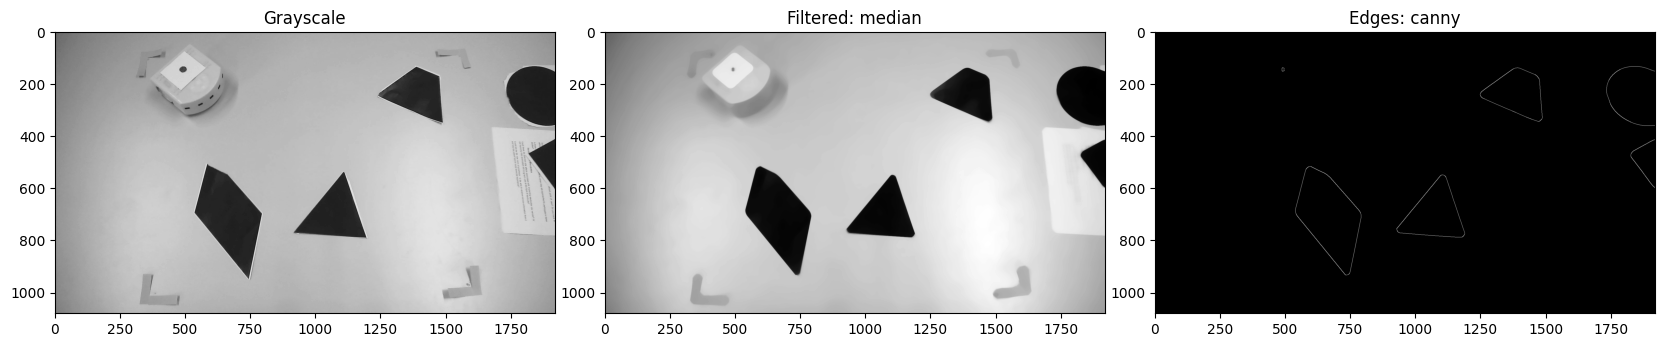

In [20]:
# Next, procure edges from camera capture 
edges = ThymioVision.getEdges(frame, verbose=True)

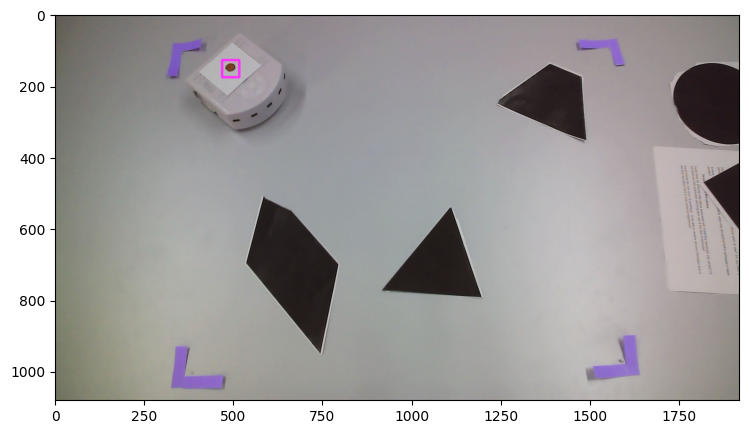

(5.4912, 2.4959999999999996)

In [21]:
pose = ThymioVision.detectBlueDot(frame, verbose=True)
ThymioVision.pixelToRealSpace(pose)

In [22]:
map = ThymioVision.getMap(frame)

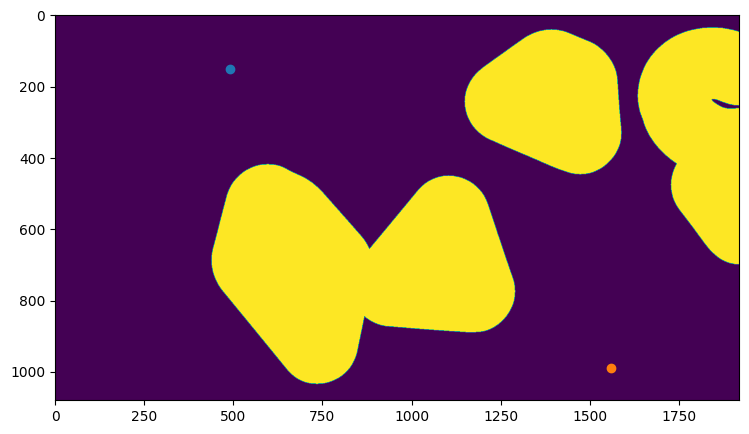

In [23]:
plt.imshow(map[0])
pose = map[1]
goal = map[2]
plt.plot([pose[0]], [pose[1]], 'o')
plt.plot([goal[0]], [goal[1]], 'o')

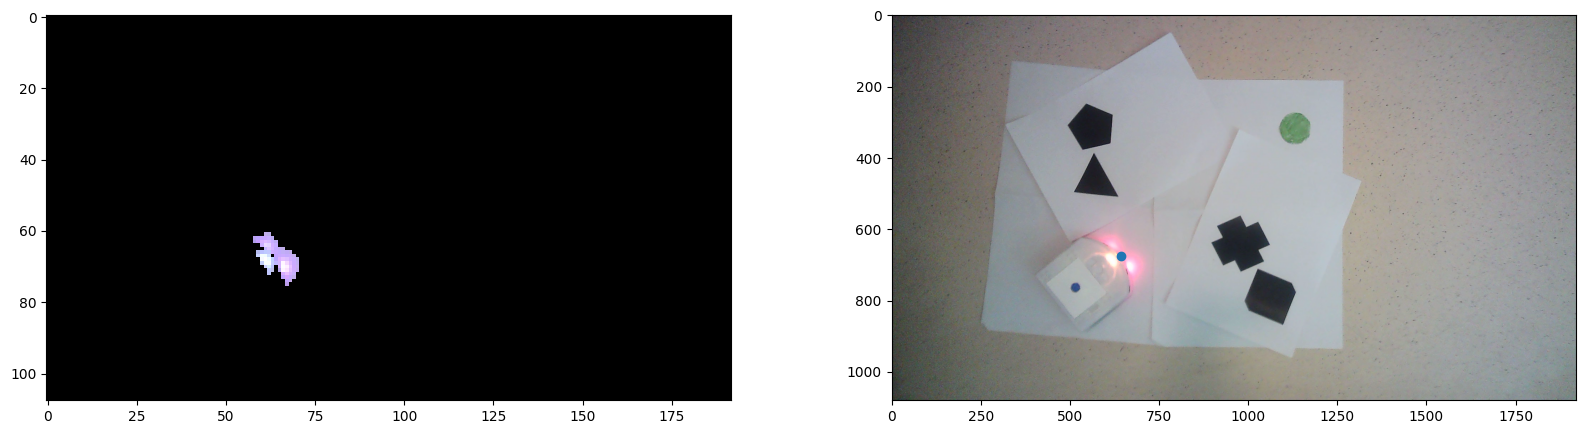

(642, 675)

In [250]:
# Test color matching from image to locate thymio
ThymioVision.detectOrangeHeading(frame, verbose=True, reduction=0.1)

In [4]:
ThymioVision.calibrateCameraPos()

2024-11-29 15:35:36.412 Python[49557:2077120] _TIPropertyValueIsValid called with 16 on nil context!
2024-11-29 15:35:36.412 Python[49557:2077120] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2024-11-29 15:35:36.412 Python[49557:2077120] Text input context does not respond to _valueForTIProperty:


In [1]:
from ThymioVision import ThymioVision
# Example usage for libe thymio tracking
import cv2
cv2.namedWindow("Camera View")
vc = cv2.VideoCapture(0)
while True:
    ret, frame = vc.read()
    if ret:
        # x1, y1, x2, y2 = ThymioVision.getThymioPose(frame)
        # cv2.circle(frame, (x1,y1), 5, (0,255,255), 3)
        # cv2.circle(frame, (x2,y2), 5, (255,0,255), 3)
        x1, y1 = ThymioVision.detectBlueDot(frame)
        cv2.circle(frame, (x1,y1), 5, (0,0,255), -1)
        print(ThymioVision.pixelToRealSpace((x1,y1)))
        cv2.imshow("Camera View", frame)
    key = cv2.waitKey(50)
    if key == ord('c'): # Escape and return image on c
        break

vc.release()
cv2.destroyAllWindows()

2024-11-29 15:38:07.845 Python[49653:2080692] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


(54.17999999999999, 50.17)
(54.17999999999999, 50.17)


2024-11-29 15:38:10.357 Python[49653:2080692] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-29 15:38:10.357 Python[49653:2080692] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


(54.17999999999999, 50.17)


2024-11-29 15:38:11.139 Python[49653:2080692] _TIPropertyValueIsValid called with 16 on nil context!
2024-11-29 15:38:11.139 Python[49653:2080692] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2024-11-29 15:38:11.139 Python[49653:2080692] Text input context does not respond to _valueForTIProperty:


(54.17999999999999, 50.17)
(54.17999999999999, 50.17)
(54.17999999999999, 50.17)


KeyboardInterrupt: 